# Pytorch starter - FasterRCNN Inference

- You can find the [train notebook here](https://www.kaggle.com/justinxu421/wheat-wack?scriptVersionId=36538878)

In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_INPUT = 'data'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

DIR_WEIGHTS = '.'

# WEIGHTS_FILE = f'{DIR_WEIGHTS}/fasterrcnn_resnet50_fpn.pth'
WEIGHTS_FILE = f'{DIR_WEIGHTS}/best_weights.pth'

In [2]:
test_df = pd.read_csv(f'{DIR_INPUT}/sample_submission.csv')
test_df.shape

(10, 2)

In [3]:
class WheatTestDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [17]:
# Albumentations
def get_test_transform():
    return A.Compose([
        # A.Resize(512, 512),
#         A.ToSepia(p=1.0),
        ToTensorV2(p=1.0)
    ])


In [5]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained weights
model.load_state_dict(torch.load(WEIGHTS_FILE))
model.eval()

x = model.to(device)

In [20]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = WheatTestDataset(test_df, DIR_TEST, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

In [21]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [22]:
detection_threshold = 0.5
results = []

for images, image_ids in test_data_loader:

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }

        
        results.append(result)


In [23]:
results[0:2]

[{'image_id': 'aac893a91',
  'PredictionString': '0.9945 66 2 107 161 0.9937 560 530 121 189 0.9934 688 388 130 171 0.9917 610 913 88 107 0.9885 552 69 142 185 0.9851 23 446 108 162 0.9850 587 775 98 118 0.9835 236 82 141 147 0.9788 737 768 82 116 0.9749 182 571 113 179 0.9738 355 525 95 84 0.9648 815 695 103 199 0.9510 456 854 84 104 0.9333 86 612 123 79 0.9175 60 849 118 72 0.9141 233 840 135 84 0.8581 337 670 110 146 0.7656 303 1 73 63 0.6396 314 867 81 87 0.5138 358 261 105 147 0.5055 821 627 83 116'},
 {'image_id': '51f1be19e',
  'PredictionString': '0.9902 274 469 136 126 0.9888 609 84 152 173 0.9885 502 465 207 109 0.9850 769 881 147 95 0.9732 809 758 102 94 0.9659 814 88 114 77 0.9633 840 262 135 200 0.9525 25 0 83 68 0.9339 696 918 83 86 0.9337 656 580 111 93 0.9147 0 375 50 114 0.8789 653 786 102 85 0.8626 247 119 103 112 0.8494 201 936 98 87 0.8367 349 134 102 166 0.8326 561 600 113 116 0.6456 902 699 110 69 0.6020 512 979 135 45 0.5003 849 649 156 78'}]

In [24]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

,image_id,PredictionString
0,aac893a91,0.9945 66 2 107 161 0.9937 560 530 121 189 0.9...
1,51f1be19e,0.9902 274 469 136 126 0.9888 609 84 152 173 0...
2,f5a1f0358,0.9961 939 428 85 188 0.9959 539 266 116 119 0...
3,796707dd7,0.9934 706 822 114 102 0.9934 376 631 101 116 ...
4,51b3e36ab,0.9979 869 287 154 141 0.9975 539 26 255 138 0...


In [25]:
sample = images[1].permute(1,2,0).cpu().numpy()
boxes = outputs[1]['boxes'].data.cpu().numpy()
scores = outputs[1]['scores'].data.cpu().numpy()

boxes = boxes[scores >= detection_threshold].astype(np.int32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


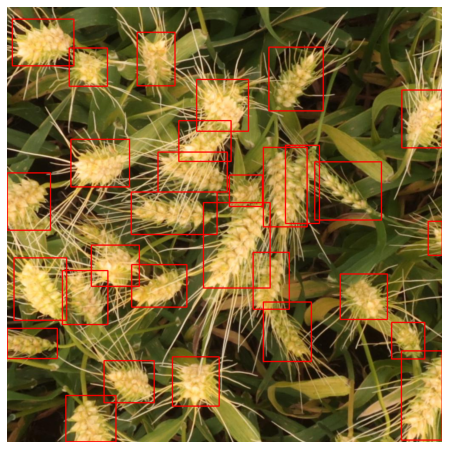

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample)

In [16]:
test_df.to_csv('submission.csv', index=False)